# Проект
В данном проекте мы пытаемся предсказать рейтинг ресторанов на основании данных с TripAdvisor.

### Список признаков датасета

* Restaurant_id — идентификационный номер ресторана / сети ресторанов;
* City — город, в котором находится ресторан;
* Cuisine Style — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;
* Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;
* Rating — рейтинг ресторана по данным TripAdvisor (это наша **целевая переменная**);
* Price Range — диапазон цен в ресторане;
* Number of Reviews — количество отзывов о ресторане;
* Reviews — данные о двух отзывах, которые отображаются на сайте ресторана;
* URL_TA — URL страницы ресторана на TripAdvisor;
* ID_TA — идентификатор ресторана в базе данных TripAdvisor.

## Импорт библиотек, загрузка датасета и первичный анализ

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import combinations

import fasttext
from dostoevsky.tokenization import RegexTokenizer       # для анализа тональности текста
from dostoevsky.models import FastTextSocialNetworkModel 

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

from ast import literal_eval
from datetime import datetime
from multiprocessing import Pool  # использовался для ускорения парсинга
import wind  # в этом модуле содержатся функции для парсинга данных,
             # они выделены в отделый модуль в связи с особенностями
             # использования multiprocessing.Pool() в Jupyter Notebook
        
import warnings
warnings.simplefilter('ignore')
        
%matplotlib inline

In [2]:
data = pd.read_csv("main_task_new.csv")
test = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")

In [3]:
data["train"] = 1 # помечаем, где у нас train
test["train"] = 0 # а где - нет
test["Rating"] = 0 # в тесте нет значений Rating, поэтому пока просто заполняем нулями
df = test.append(data, sort=False).reset_index(drop=True) # объединяем

In [4]:
df.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,train,Rating
3465,id_3465,Helsinki,"['Seafood', 'European', 'Scandinavian', 'Glute...",142.0,$$ - $$$,165.0,"[['Amazing fish restaurant', 'Good food, frien...",/Restaurant_Review-g189934-d7946045-Reviews-Ra...,d7946045,0,0.0
48923,id_1841,Madrid,"['Spanish', 'Mediterranean']",1843.0,$$ - $$$,124.0,"[['Cheerful, friendly staff and great tostas',...",/Restaurant_Review-g187514-d2049331-Reviews-Ta...,d2049331,1,4.0
21101,id_1281,Edinburgh,NaN,1282.0,NaN,10.0,"[['Best chips in town', 'The Shop I Judge All ...",/Restaurant_Review-g186525-d4925360-Reviews-Fr...,d4925360,1,4.5
36673,id_1198,Dublin,['Chinese'],1201.0,NaN,NaN,"[['Great food, great value'], ['09/09/2012']]",/Restaurant_Review-g186605-d2660122-Reviews-Ti...,d2660122,1,5.0
21280,id_10776,Paris,NaN,10778.0,NaN,2.0,"[[], []]",/Restaurant_Review-g187147-d7062912-Reviews-L_...,d7062912,1,4.0


In [5]:
df.columns = ["id", "city", "cuisines", "ranking", "price_range",
              "number_of_reviews", "reviews", "link", "id2", "train", "rating"]

In [6]:
target_name = "rating"

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 50000 non-null  object 
 1   city               50000 non-null  object 
 2   cuisines           38410 non-null  object 
 3   ranking            50000 non-null  float64
 4   price_range        32639 non-null  object 
 5   number_of_reviews  46800 non-null  float64
 6   reviews            49998 non-null  object 
 7   link               50000 non-null  object 
 8   id2                50000 non-null  object 
 9   train              50000 non-null  int64  
 10  rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [8]:
df.describe()

,ranking,number_of_reviews,train,rating
count,50000.000000,46800.000000,50000.000000,50000.000000
mean,3664.427520,124.471197,0.800000,3.194430
std,3700.092452,294.114345,0.400004,1.705453
min,1.000000,2.000000,0.000000,0.000000
25%,972.000000,9.000000,1.000000,3.000000
50%,2278.000000,33.000000,1.000000,4.000000
75%,5241.000000,115.000000,1.000000,4.500000
max,16444.000000,9660.000000,1.000000,5.000000


## Некоторые функции

In [9]:
def outliers(df_col, df=df):
    # Определение наличия выбросов и их границ.
    
    q1 = df[df_col].quantile(0.25)
    q3 = df[df_col].quantile(0.75)
    iqr = q3 - q1
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr
    
    print(f"25-й процентиль: {q1}, 75-й процентиль: {q3}, IQR: {iqr}, Границы выбросов: [{low}, {high}]")
    print(f"Количество выбросов в признаке '{df_col}':\
    {((df[df_col] < low) | (df[df_col] > high)).sum()}")

In [10]:
def get_boxplot(df_col):
    # выводит boxplot для анализируемого признака
    
    fig, ax = plt.subplots(figsize = (12, 4))
    sns.boxplot(x=df_col, y='rating', data=df, fliersize=8, ax=ax)
    plt.xticks(rotation=90)
    plt.show();

In [11]:
# copied from https://towardsdatascience.com/are-you-dropping-too-many-correlated-features-d1c96654abe6
def features_to_drop(df, cut=0.9):
    """
    На основании коэффицентов корреляции определяет признаки, которые стоит удалить
    
    df - датафрейм
    cut - пороговое значение коэффициента корреляции
    """

    corr_mtx = df.corr() # создаём корреляционную матрицу
    avg_corr = corr_mtx.mean(axis=1) # считаем среднюю корреляцию по признакам
    up = corr_mtx.where(np.triu(np.ones(corr_mtx.shape), k=1).astype(np.bool)) 
    # создаём верхний треугольник матрицы 
    # нижний не несёт дополнительной информации, так как матрица корреляций симметрична

    drop = [] # будущий список признаков для удаления

    for row in range(len(up)-1): # проходимся по всем строкам матрицы
        for col in range(row + 1, len(up)): # проходимся по всем столбцам
            if(abs(corr_mtx.iloc[row, col]) > cut): # если корреляция двух текущих признаков больше пороговой,
                # то удалим один из них (тот, у которого средняя корреляция больше):
                if(abs(avg_corr.iloc[row]) > abs(avg_corr.iloc[col])):
                    drop.append(row)
                else:
                    drop.append(col)

    dropcols_names = list(df.columns[[item for item in list(set(drop))]])
    
    if dropcols_names:
        return dropcols_names
    
    print("Сильноскоррелированных переменных нет")

## Работа с пропусками

In [12]:
df.isna().sum()

id                       0
city                     0
cuisines             11590
ranking                  0
price_range          17361
number_of_reviews     3200
reviews                  2
link                     0
id2                      0
train                    0
rating                   0
dtype: int64

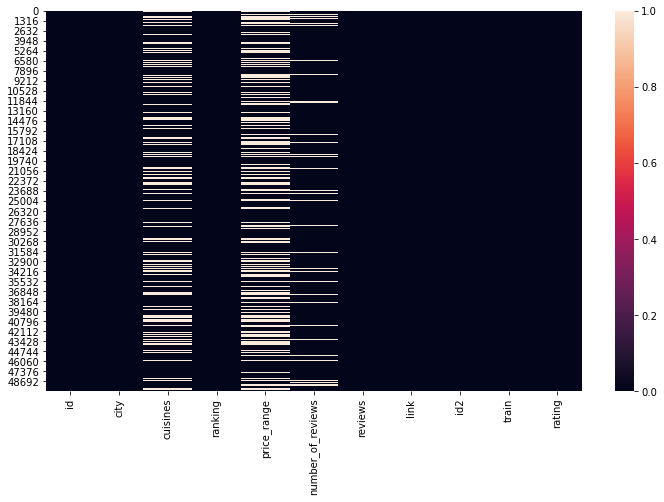

In [13]:
plt.subplots(figsize=(12, 7))
sns.heatmap(df.isna());

Пропуски присутсвуют в столбцах *cuisines*, *price_range* и *number_of_reviews*, попробуем спарсить часть 
недостающих данных.
Также обратим внимание на признак reviews, где часть значений - пустой список  списков:

In [14]:
len(df[df.reviews == "[[], []]"])

8112

In [15]:
df.reviews.fillna("[[], []]", inplace=True)

In [16]:
len(df[df.reviews == "[[], []]"])

8114

In [17]:
df["reviews_nan"] = (df["reviews"]=="[[], []]").astype("int")

### Парсинг недостающих данных

####  cuisines

In [18]:
df.cuisines.isna().sum()

11590

Парсинг информации о типах кухонь длился около полутора часов (1:27:46) в многопоточном режиме (при помощи multiprocessing.Pool()), после чего полученная информация (cuisines) была объеденина с индексами (id2) в датафрейме res и сохранена в csv. 

In [19]:
# url = "https://www.tripadvisor.com"
# links = [f"{url}{i}" for i in df[df.cuisines.isna()].link]
# ids = [i for i in df[df.cuisines.isna()].id2]
# # делаем список ссылок на те рестораны, по которым у нас отсутсвует информация (и мы надеемся её восполнить)
# # также собираем id этих ресторанов 

In [20]:
# if __name__ == '__main__':
#     start = datetime.now() # засекаем время
#     with Pool() as p: # используем многопоточность, чтобы ускорить парсинг
#         cuisines = p.map(wind.get_cuisines, links)
#     end = datetime.now()
#     print(end - start) # печатаем, сколько времени ушло на выполение ячейки

In [21]:
# res = pd.concat([pd.Series(ids), pd.Series(cuisines)], axis=1)
# res.columns = ["id2", "cuisine"]
# res

In [22]:
#res.to_csv("cuisines.csv", index=False)

In [23]:
cuisines = pd.read_csv("cuisines.csv") # загрузим результат парсинга обратно в блокнот
cuisines.sample(5)

,id2,cuisine
1571,d10760037,['Cafe']
2498,d5971427,['Spanish']
208,d1017382,NaN
8382,d10818781,"['Polish', 'European']"
2670,d12681755,"['Dessert', 'Cafe', 'Vegetarian Friendly']"


In [24]:
len(cuisines) == df.cuisines.isna().sum() # проверим, что спарсилась вся информация

True

Добавим теперь новые данные в датафрейм df:

In [25]:
union = pd.merge(df, cuisines, how='outer')
union.drop_duplicates(inplace=True)
union.reset_index(drop=True)
union['cuisines'] = union[['cuisines', 'cuisine']].apply(lambda x: x[1] if pd.isna(x[0]) else x[0], axis=1)
union.drop(['cuisine'], axis=1, inplace=True)

In [26]:
union.head()

,id,city,cuisines,ranking,price_range,number_of_reviews,reviews,link,id2,train,rating,reviews_nan
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,1
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,0


In [27]:
df = union

In [28]:
df.cuisines.isna().sum() # нам удалось заполнить половину пропусков

5849

In [29]:
df["cuisines_nan"] = pd.isna(df["cuisines"]).astype("int")

In [30]:
df["cuisines"] = df.groupby("city")["cuisines"].\
    transform(lambda x: x.fillna(x.mode()[0]))

Повторим парсинг и замену для других признаков с пропусками

####  price_range

In [31]:
df.price_range.isna().sum()

17361

Время парсинга недостающих данных о диапазоне цен - более 2-х часов.

In [32]:
# links = [f"{url}{i}" for i in df[df.price_range.isna()].link]
# ids = [i for i in df[df.price_range.isna()].id2]

In [33]:
# if __name__ == '__main__':
#     start = datetime.now() # засекаем время
#     with Pool() as p: # используем многопоточность, чтобы ускорить парсинг
#         price_range = p.map(wind.get_price_range, links)
#     end = datetime.now()
#     print(end - start) # печатаем, сколько времени ушло на выполение ячейки

In [34]:
# res = pd.concat([pd.Series(ids), pd.Series(price_range)], axis=1)
# res.columns = ["id2", "price_ran"]
# res

In [35]:
#res.to_csv("price_range.csv", index=False)

In [36]:
price_range = pd.read_csv("price_range.csv")
price_range.sample(5)

,id2,price_ran
4602,d3567660,NaN
16186,d13123995,NaN
3883,d12322498,NaN
8385,d12351755,$
11957,d2719664,NaN


In [37]:
len(price_range) == df.price_range.isna().sum()

True

In [38]:
union = pd.merge(df, price_range, how='outer')
union.drop_duplicates(inplace=True)
union.reset_index(drop=True, inplace=True)
union['price_range'] = union[['price_range', 'price_ran']].apply(lambda x: x[1] if pd.isna(x[0]) else x[0],axis=1)
union.drop(['price_ran'], axis=1, inplace=True)

In [39]:
df = union

In [40]:
df.price_range.isna().sum() # мы смогли уменьшить количество пропусков почти вдвое

9476

In [41]:
df["price_range_nan"] = pd.isna(df["price_range"]).astype("int")

In [42]:
price_dict = {'$': 1,
              '$$ - $$$': 2,
              '$$$$': 3}

In [43]:
df["price_range"] = df["price_range"].map(price_dict)
# закодируем ценовой диапазон числами (это корректно, потому что переменная ординальная)

In [44]:
df.price_range.value_counts()

2.0    27443
1.0    11144
3.0     1937
Name: price_range, dtype: int64

In [45]:
df.price_range.fillna(df.price_range.mode()[0], inplace=True)

In [46]:
df.price_range.value_counts()

2.0    36919
1.0    11144
3.0     1937
Name: price_range, dtype: int64

#### number_of_reviews

In [47]:
df.number_of_reviews.isna().sum()

3200

Время парсинга количества отзывов - 20 минут.

In [48]:
# links = [f"{url}{i}" for i in df[df.number_of_reviews.isna()].link]
# ids = [i for i in df[df.number_of_reviews.isna()].id2]

In [49]:
# if __name__ == '__main__':
#     start = datetime.now()
#     with Pool() as p:
#         num_of_reviews = p.map(wind.get_num_of_reviews, links[:10])
#     end = datetime.now()
#     print(end - start)

In [50]:
# num_of_reviews

In [51]:
# res = pd.concat([pd.Series(ids), pd.Series(num_of_reviews)], axis=1)
# res.columns = ["id2", "num_of_reviews"]
# res

In [52]:
# res.to_csv("number_of_reviews.csv", index=False)

In [53]:
num_of_reviews = pd.read_csv("number_of_reviews.csv")

In [54]:
union = pd.merge(df, num_of_reviews, how='outer')
union['number_of_reviews'] = union[['number_of_reviews', 'num_of_reviews']].apply(lambda x: x[1] if pd.isna(x[0]) else x[0],axis=1)
union.drop(['num_of_reviews'], axis=1, inplace=True)

In [55]:
df = union

In [56]:
df.number_of_reviews.isna().sum() # количество пропусков сократилось впятеро(!)

561

In [57]:
df["number_of_reviews_nan"] = pd.isna(df["number_of_reviews"]).astype("int")

In [58]:
df["number_of_reviews"] = df.groupby("city")["number_of_reviews"].\
    transform(lambda x: x.fillna(x.median()))

In [59]:
df.isna().sum() # проверим, что мы заполнили все пропуски

id                       0
city                     0
cuisines                 0
ranking                  0
price_range              0
number_of_reviews        0
reviews                  0
link                     0
id2                      0
train                    0
rating                   0
reviews_nan              0
cuisines_nan             0
price_range_nan          0
number_of_reviews_nan    0
dtype: int64

### Работа с числовыми признаками

* ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;
* rating — рейтинг ресторана по данным TripAdvisor (это наша **целевая переменная**);
* number_of_reviews — количество отзывов о ресторане.

#### ranking

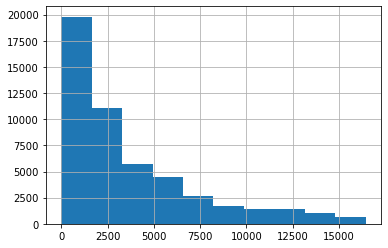

In [60]:
df.ranking.hist();

In [61]:
outliers("ranking")

25-й процентиль: 972.0, 75-й процентиль: 5241.0, IQR: 4269.0, Границы выбросов: [-5431.5, 11644.5]
Количество выбросов в признаке 'ranking':    3075


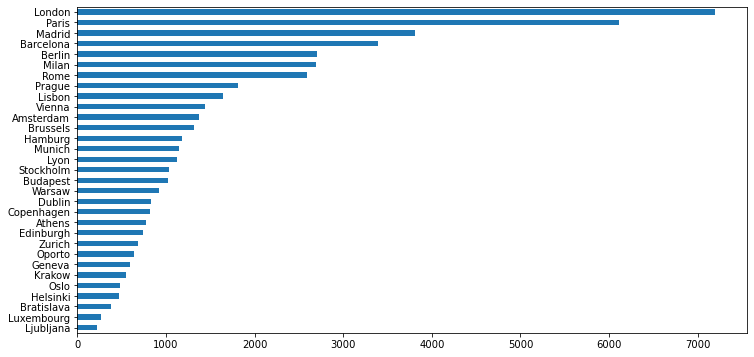

In [62]:
plt.rcParams['figure.figsize'] = (12,6)
df['city'].value_counts(ascending=True).plot(kind='barh');

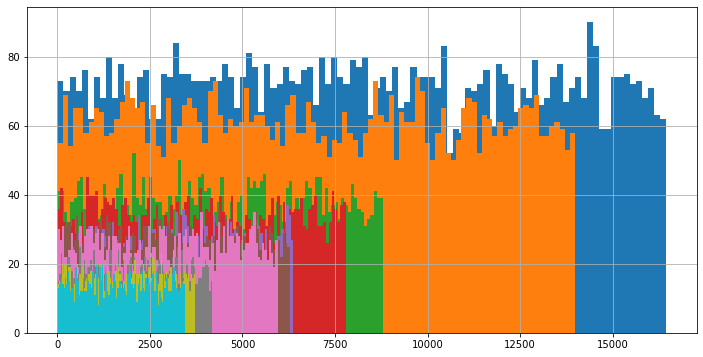

In [63]:
for x in (df['city'].value_counts())[:10].index:
    df['ranking'][df['city'] == x].hist(bins=100)
plt.show()

In [64]:
# Распределения ranking очень похожи, 
# просто в больших городах больше ресторанов, и из-за мы этого имеем смещение.
# Отнормируем ranking по городам
mean_ranking_by_city = df.groupby(['city'])['ranking'].mean()
number_of_restaurants = dict(df['city'].value_counts())

In [65]:
number_of_restaurants = df["city"].map(number_of_restaurants)
mean_ranking_by_city = df["city"].apply(lambda x: mean_ranking_by_city[x])

In [66]:
df["norm_ranking"] = (df["ranking"] - mean_ranking_by_city) / number_of_restaurants

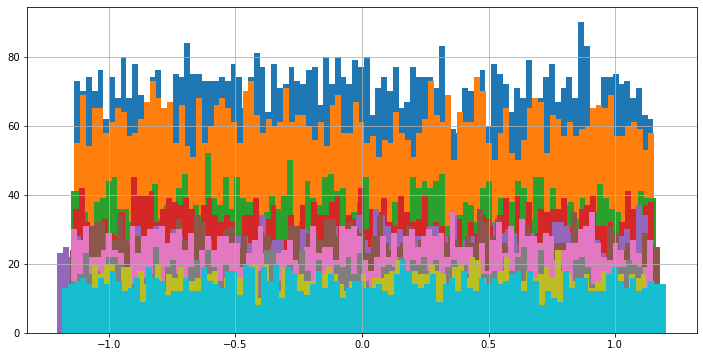

In [67]:
for x in (df["city"].value_counts())[:10].index:
    df["norm_ranking"][df["city"] == x].hist(bins=100)
plt.show()

#### rating

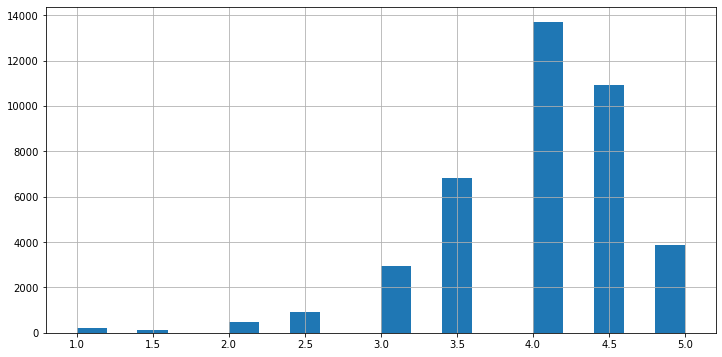

In [68]:
df[df["rating"] > 0]["rating"].hist(bins=20);

#### number_of_reviews

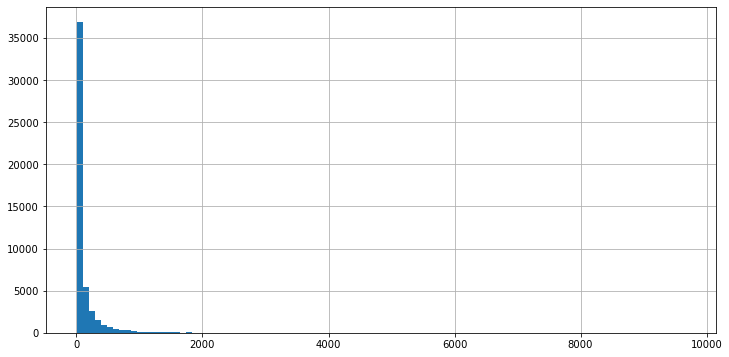

In [69]:
df.number_of_reviews.hist(bins=100);

In [70]:
outliers("number_of_reviews")
# Наблюдаем большое число выбросов за правой границей, возможно, это накрученные отзывы

25-й процентиль: 9.0, 75-й процентиль: 115.0, IQR: 106.0, Границы выбросов: [-150.0, 274.0]
Количество выбросов в признаке 'number_of_reviews':    5428


In [71]:
df.loc[df["number_of_reviews"] > 1200, "number_of_reviews"] = 1200

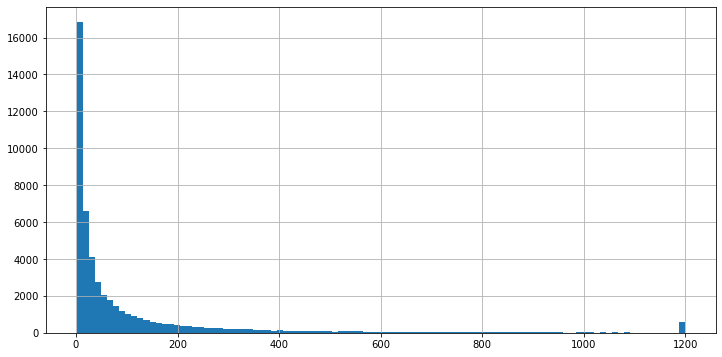

In [72]:
df.number_of_reviews.hist(bins=100);

In [73]:
border = df["number_of_reviews"].quantile(0.75)
df["popular"] = df["number_of_reviews"].apply(lambda x: 1 if x > border else 0)
df["popular"].value_counts()

0    37530
1    12470
Name: popular, dtype: int64

### Работа с нечисловыми признаками

* id — идентификационный номер ресторана / сети ресторанов;
* сity — город, в котором находится ресторан;
* cuisines — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;
* price_range — диапазон цен в ресторане;
* reviews — данные о двух отзывах, которые отображаются на сайте ресторана;
* link — URL страницы ресторана на TripAdvisor;
* id2 — идентификатор ресторана в базе данных TripAdvisor.

#### id

In [74]:
rest_count = df.id.value_counts()
restaurant_chain_list = rest_count[rest_count >= 2].index.tolist()
# создадим список сетевых ресторанов для будущего признака is_restaurant_chain

In [75]:
def is_chain(x):
    if x in restaurant_chain_list:
        return 1
    else:
        return 0

In [76]:
df["is_restaurant_chain"] = df.id.apply(is_chain)

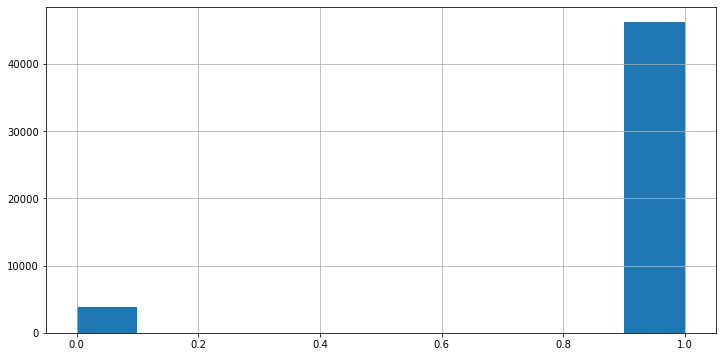

In [77]:
df["is_restaurant_chain"].hist();

#### city

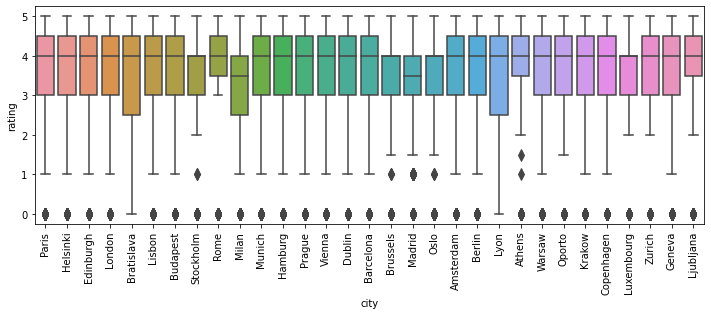

In [78]:
get_boxplot(df.city)

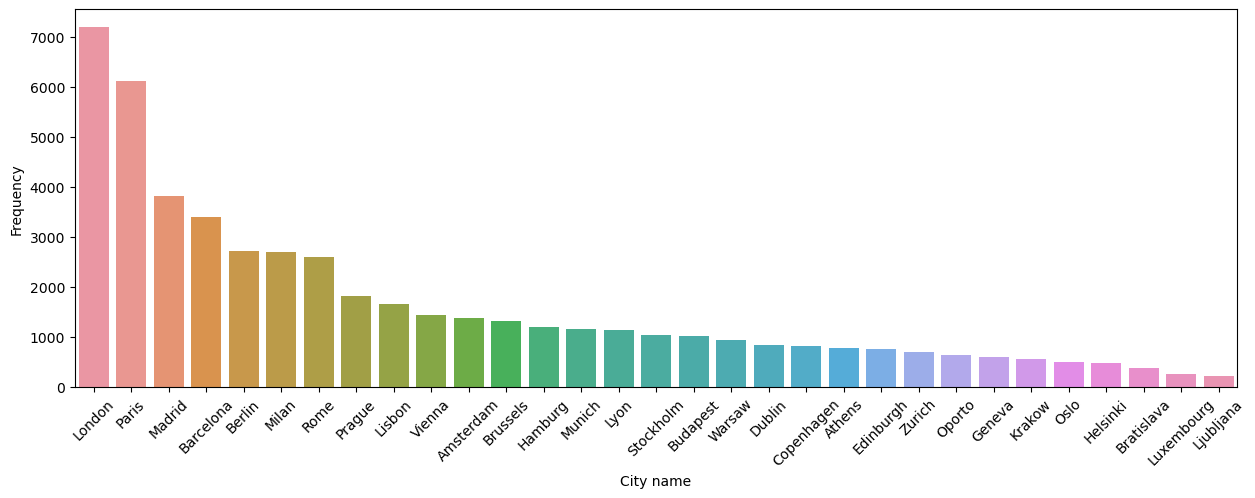

In [79]:
plt.figure(figsize=(15, 5), dpi=100)
sns.countplot(df["city"], order=df["city"].value_counts().index)
plt.xticks(rotation=45)
plt.xlabel("City name")
plt.ylabel("Frequency");

In [80]:
df.loc[df.city == "Oporto", "city"] = "Porto"

In [81]:
not_capital = ["Barcelona", "Milan", "Hamburg", "Munich", 
               "Lyon", "Zurich", "Porto", "Geneva", "Krakow"]
df["is_capital"] = df["city"].apply(lambda x: 0 if x in not_capital else 1) 

In [82]:
cities = list(df.city.unique())

In [83]:
data = pd.read_csv("cities.csv") # загрузим сторонние данные о городах (такие как стоимость жизни или уровень образования)
                                 # источник: https://www.kaggle.com/orhankaramancode/city-quality-of-life-dataset

In [84]:
data.head()

,city,housing,cost_of_living,startups,venture_capital,travel_connectivity,commute,business_freedom,safety,healthcare,education,environment,economy,taxation,internet_access,leisure_and_culture,tolerance,outdoors
0,Aarhus,6.1315,4.015,2.8270,2.512,3.5360,6.31175,9.940000,9.6165,8.704333,5.3665,7.63300,4.8865,5.0680,8.373,3.1870,9.7385,4.1300
1,Adelaide,6.3095,4.692,3.1365,2.640,1.7765,5.33625,9.399667,7.9260,7.936667,5.1420,8.33075,6.0695,4.5885,4.341,4.3285,7.8220,5.5310
2,Albuquerque,7.2620,6.059,3.7720,1.493,1.4555,5.05575,8.671000,1.3435,6.430000,4.1520,7.31950,6.5145,4.3460,5.396,4.8900,7.0285,3.5155
3,Almaty,9.2820,9.333,2.4585,0.000,4.5920,5.87125,5.568000,7.3090,4.545667,2.2830,3.85675,5.2690,8.5220,2.886,2.9370,6.5395,5.5000
4,Amsterdam,3.0530,3.824,7.9715,6.107,8.3245,6.11850,8.836667,8.5035,7.907333,6.1800,7.59725,5.0530,4.9550,4.523,8.8740,8.3680,5.3070


In [85]:
df = df.merge(data, how="left") # добавим данные в исходный датафрейм

In [86]:
city_population = {
    'Paris': 2_187_526,
    'Stockholm': 975_551,
    'London': 8_982_000,
    'Berlin': 3_769_000,
    'Munich': 1_472_000,
    'Porto': 214_349,
    'Milan': 1_352_000,
    'Bratislava': 424_428,
    'Vienna': 1_897_000,
    'Rome': 2_873_000,
    'Barcelona': 5_575_000,
    'Madrid': 6_642_000,
    'Dublin': 1_388_000,
    'Brussels': 174_383,
    'Zurich': 402_762,
    'Warsaw': 1_708_000,
    'Budapest': 1_752_000,
    'Copenhagen': 602_481,
    'Amsterdam': 821_752,
    'Lyon': 513_275,
    'Hamburg': 1_845_000,
    'Lisbon': 504_718,
    'Prague': 1_309_000,
    'Oslo': 681_067,
    'Helsinki': 631_695,
    'Edinburgh': 482_005,
    'Geneva': 499_480,
    'Ljubljana': 279_631,
    'Athens': 664_046,
    'Luxembourg': 124_528,
    'Krakow': 762_508
}

In [87]:
df["population"] = df["city"].map(city_population)

In [88]:
purchasing_power_index = {
    'London' : 24,
    'Paris' : 22,
    'Madrid' : 23,
    'Barcelona' : 30,
    'Berlin' : 8,
    'Milan' : 40,
    'Rome' : 37,
    'Prague' : 31,
    'Lisbon' : 48,'Vienna' : 21,
    'Amsterdam' : 19,
    'Brussels' : 15,
    'Hamburg' : 7,
    'Munich' : 6,
    'Lyon' : 70,
    'Stockholm' : 13,
    'Budapest' : 51,
    'Warsaw' : 29,
    'Dublin' : 27,
    'Copenhagen' : 10,
    'Athens' : 53,
    'Edinburgh' : 16, 
    'Zurich' : 2,
    'Porto' : 42,
    'Geneva' : 3, 
    'Krakow' : 36, 
    'Oslo' : 17, 
    'Helsinki' : 9,
    'Bratislava' : 39,
    'Luxembourg' : 4,
    'Ljubljana' : 32
}

In [89]:
df["purchasing_power_index"] = df["city"].map(purchasing_power_index)

In [90]:
tourist_attract = {
    'London' : 1,
    'Paris' : 1,
    'Madrid' : 2,
    'Barcelona' : 2,
    'Berlin' : 2,
    'Milan' : 5,
    'Rome' : 1,
    'Prague' : 1,
    'Lisbon' : 3,
    'Vienna' : 2,
    'Amsterdam' : 1,
    'Brussels' : 3,
    'Hamburg' : 5,
    'Munich' : 3,
    'Lyon' : 5,
    'Stockholm' : 4,
    'Budapest' : 3,
    'Warsaw' : 3,
    'Dublin' : 5,
    'Copenhagen' : 3,
    'Athens' : 2,
    'Edinburgh' : 5, 
    'Zurich' : 5,
    'Porto' : 4,
    'Geneva' : 5, 
    'Krakow' : 3, 
    'Oslo' : 5, 
    'Helsinki' : 5,
    'Bratislava' : 5,
    'Luxembourg' : 5,
    'Ljubljana' : 5
}

In [91]:
df["tourist_attraction"] = df["city"].map(tourist_attract)

In [92]:
gdp = {
    'Paris': 45_454,
    'Stockholm': 52_477,
    'London': 44_288,
    'Berlin': 53_571,
    'Munich': 53_571,
    'Porto': 33_131,
    'Milan': 40_066,
    'Bratislava': 32_184, 
    'Vienna': 55_406,
    'Rome': 40_066,
    'Barcelona': 38_143,
    'Madrid': 38_143,
    'Dublin': 89_383,
    'Brussels': 50_114,
    'Zurich': 68_340,
    'Warsaw': 33_739,
    'Budapest': 32_434,
    'Copenhagen': 57_781,
    'Amsterdam': 57_101,
    'Lyon': 45_454,
    'Hamburg': 53_571,
    'Lisbon': 33_131,
    'Prague': 40_293,
    'Oslo': 64_856,
    'Helsinki': 49_334,
    'Edinburgh': 44_288,
    'Geneva': 68_340,
    'Ljubljana': 38_506,
    'Athens': 29_045,
    'Luxembourg': 112_875,
    'Krakow': 33_739
}

In [93]:
df["gdp"] = df["city"].map(gdp)

In [94]:
restaurants_by_city = df.city.value_counts()
df["number_of_restaurants"] = df.city.apply(lambda x: restaurants_by_city[x])

In [95]:
df["people_per_rest"] = df["population"] / df["number_of_restaurants"]

In [96]:
df.sample(5)

,id,city,cuisines,ranking,price_range,number_of_reviews,reviews,link,id2,train,...,internet_access,leisure_and_culture,tolerance,outdoors,population,purchasing_power_index,tourist_attraction,gdp,number_of_restaurants,people_per_rest
29924,id_7912,Madrid,['American'],7919.0,2.0,4.0,"[[], []]",/Restaurant_Review-g187514-d7595637-Reviews-Re...,d7595637,1,...,6.2410,9.3380,7.665,6.2200,6642000,23,2,38143,3813,1741.935484
23011,id_3904,London,"['Fast Food', 'Middle Eastern', 'Halal']",3911.0,1.0,106.0,"[['The Best.', 'The Best on KINGS ROAD'], ['07...",/Restaurant_Review-g186338-d1195259-Reviews-Ke...,d1195259,1,...,5.8455,9.4555,6.573,5.3745,8982000,24,1,44288,7193,1248.714028
7750,id_7737,London,"['Steakhouse', 'European', 'British', 'Scottis...",1843.0,3.0,234.0,"[['Always delivers', 'Steak and Jazz'], ['01/0...",/Restaurant_Review-g186338-d1386569-Reviews-Bo...,d1386569,0,...,5.8455,9.4555,6.573,5.3745,8982000,24,1,44288,7193,1248.714028
18204,id_7277,London,"['Lebanese', 'Mediterranean', 'Middle Eastern'...",7286.0,1.0,45.0,"[[""LAMB SHERWAMA - IT'S A WRAP"", 'Very Good Le...",/Restaurant_Review-g186338-d3862786-Reviews-Be...,d3862786,1,...,5.8455,9.4555,6.573,5.3745,8982000,24,1,44288,7193,1248.714028
14359,id_1672,Vienna,"['Austrian', 'Cafe', 'European']",1673.0,2.0,4.0,"[[], []]",/Restaurant_Review-g190454-d12154545-Reviews-C...,d12154545,1,...,6.1730,8.5215,8.964,5.2945,1897000,21,2,55406,1443,1314.622315


#### cuisines

In [97]:
df["cuisines"] = df.cuisines.apply(literal_eval)
# превратим почти списки в настоящие списки

In [98]:
# cuisine_frequency = df.cuisines.explode().value_counts() # посчитаем частоту встречаемости кухонь
# least_popular = cuisine_frequency[cuisine_frequency < 50].index # посмотрим наименее популярные кухни

In [99]:
# def rare_cuisine_count(cell):
#     number = 0
#     for i in least_popular:
#         if i in cell:
#             number += 1
#     return number

In [100]:
# df["rare_cuisines"] = df["cuisines"].apply(rare_cuisine_count)

In [101]:
# get_boxplot("rare_cuisines")

In [102]:
df["number_of_cuisines"] = df.cuisines.apply(lambda x: len(x)) 
# сделаем признак количества кухонь в ресторане

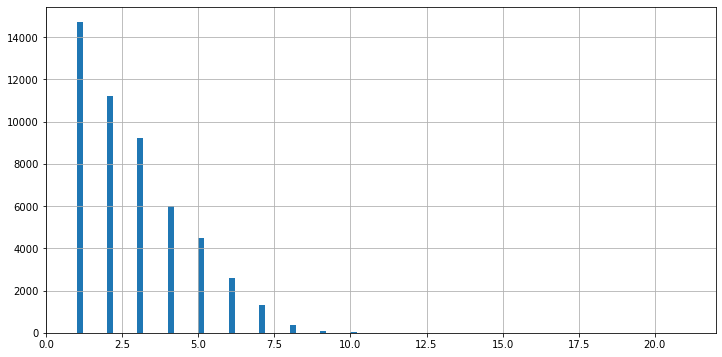

In [103]:
df["number_of_cuisines"].hist(bins=100);

In [104]:
cuisines = df["cuisines"].explode().value_counts(ascending=False).index
top_cuisines = cuisines[:5].tolist()

In [105]:
for col in top_cuisines:
    df[col.lower().replace(" ", "_")] = df["cuisines"].apply(lambda x: 1 if col in x else 0)
    
df["other_cuisines"] = df["cuisines"].apply(lambda x: 1 if all([cus not in top_cuisines for cus in x]) else 0)

In [106]:
cuisines_by_city = {} # посчитаем, сколько кухонь встречается в каждом из городов
for city in cities:
    cuisines_by_city[city] = len(df[df["city"] == city].cuisines.explode().value_counts())

In [107]:
cuisines_in_city = df["city"].map(cuisines_by_city)

In [108]:
df["weighed_cuisines_count"] = df["number_of_cuisines"] / cuisines_in_city

In [109]:
# def got_vegan(row):
#     vegan_cuisines = ["Vegetarian Friendly", "Vegan Options", "Gluten Free Options", "Healthy"]
#     for i in vegan_cuisines:
#         if i in row["cuisines"]:
#             return 1
#     return 0

In [110]:
# def got_junk_food(row):
#     pop_cuisines = ["Cafe", "Grill", "International", "Mediterranean", "Fast Food", "Pizza", "Pub", "Sushi"]
#     for i in pop_cuisines:
#         if i in row["cuisines"]:
#             return 1
#     return 0

In [111]:
# df["vegan_include"] = df.apply(got_vegan, axis=1)

In [112]:
# df["popular_cuisine_include"] = df.apply(got_junk_food, axis=1)

In [113]:
df.sample(5)

,id,city,cuisines,ranking,price_range,number_of_reviews,reviews,link,id2,train,...,number_of_restaurants,people_per_rest,number_of_cuisines,european,vegetarian_friendly,italian,mediterranean,vegan_options,other_cuisines,weighed_cuisines_count
23825,id_1126,Paris,"[French, European]",1127.0,2.0,314.0,"[['To discover!', 'Excellent despite tourists'...",/Restaurant_Review-g187147-d945853-Reviews-La_...,d945853,1,...,6108,358.141126,2,1,0,0,0,0,0,0.018182
15575,id_4798,Berlin,[German],4800.0,1.0,4.0,"[['Standard Berlin ""Backshop"" or bakery but w....",/Restaurant_Review-g187323-d5820326-Reviews-Ca...,d5820326,1,...,2705,1393.345656,1,0,0,0,0,0,1,0.009615
12334,id_5229,London,"[Bar, International, British, European]",5238.0,2.0,72.0,"[['Lunchtime visit', 'Great bar just off the m...",/Restaurant_Review-g186338-d698007-Reviews-The...,d698007,1,...,7193,1248.714028,4,1,0,0,0,0,0,0.034483
46370,id_3903,Prague,[Cafe],3912.0,2.0,3.0,"[[], []]",/Restaurant_Review-g274707-d7123287-Reviews-Ca...,d7123287,1,...,1816,720.814978,1,0,0,0,0,0,1,0.011494
30619,id_5780,Paris,[Delicatessen],5781.0,2.0,75.0,"[[""be careful!! They're con artist"", 'The best...",/Restaurant_Review-g187147-d5797162-Reviews-So...,d5797162,1,...,6108,358.141126,1,0,0,0,0,0,1,0.009091


#### price_range

In [114]:
df.price_range.unique() # мы уже закодировали признак

array([2., 3., 1.])

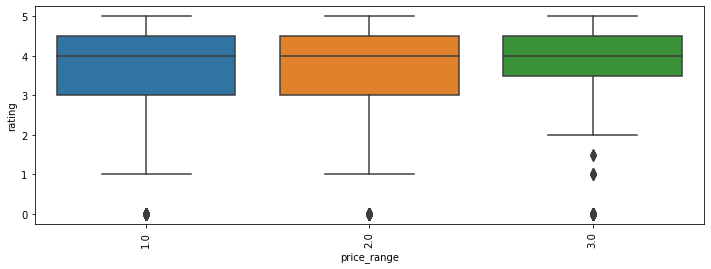

In [115]:
get_boxplot("price_range")

#### reviews

In [116]:
df.loc[df.reviews == "[['Will certainly be back', nan], ['11/26/2017', '07/27/2017']]", "reviews"] = \
    "[['Will certainly be back', ''], ['11/26/2017', '07/27/2017']]"
df.loc[df.reviews == "[[nan, 'Good food with decent service'], ['11/21/2017', '07/21/2017']]", "reviews"] = \
    "[['', 'Good food with decent service'], ['11/21/2017', '07/21/2017']]"
# заменим два значения, содержащие nan

In [117]:
df.reviews = df.reviews.apply(literal_eval) # превращаем почти списки в списки

In [118]:
df["one_review"] = (df.reviews.apply(lambda x: len(x[1]))==1).astype('int')

In [119]:
tokenizer = RegexTokenizer()

In [120]:
fasttext.FastText.eprint = lambda x: None # магическая строчка, подавляющая warning (посмотрите, что будет без неё)
predictor = FastTextSocialNetworkModel(tokenizer=tokenizer)

In [121]:
def analyser(reviews):
    result = predictor.predict(reviews[0], k=5) 
    # с помощью библиотеки dostoevsky проанализируем тональность отзывов
    if len(reviews[0]) == 0:
        return 0, 0
    elif len(reviews[0]) == 1:
        return result[0]["positive"], 0
    else:
        return result[0]["positive"], result[1]["positive"]

In [122]:
tone = df.reviews.apply(analyser)
tone.head()

0                                           (0, 0)
1       (0.22816647589206696, 0.03623005375266075)
2    (0.08270734548568726, 1.0000003385357559e-05)
3      (0.006913838442414999, 0.01591639406979084)
4        (0.03022458776831627, 0.0695517510175705)
Name: reviews, dtype: object

In [123]:
df["positive"], df["positive2"] = tone.apply(lambda x: x[0]), tone.apply(lambda x: x[1])

In [124]:
def time_to_now(row):
    dates = []
    for date in row[1]:
        dates.append(datetime.strptime(date, '%m/%d/%Y'))
    if len(dates) >= 1:
        return (datetime.now() - sorted(dates, reverse=True)[0]).days
    return 0

In [125]:
def timedifference(row):
    dates = []
    for date in row[1]:
        dates.append(datetime.strptime(date, '%m/%d/%Y').timestamp())
    if len(dates) == 2:
        return abs(dates[0] - dates[1])
    return 0

In [126]:
df["time_from_last_review"] = df.reviews.apply(time_to_now)

In [127]:
df["time_difference"] = df.reviews.apply(timedifference)

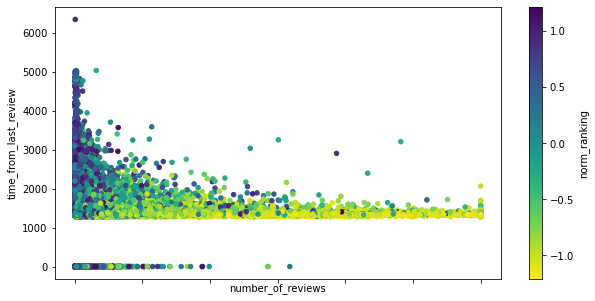

In [128]:
plt.rcParams["figure.figsize"] = (10.0, 5.0)
ax = df.plot.scatter(x="number_of_reviews", y="time_from_last_review", c="norm_ranking", colormap="viridis_r")
ax.xaxis.get_label().set_visible(True)

#### link
Мы уже использовали ссылки для парсинга, удалим их.

#### id2

In [129]:
df.id2 = df.id2.apply(lambda x: x[1:]).astype("int")

In [130]:
df.drop(["id", "city", "cuisines", "reviews", "link", "ranking", "positive2", "price_range", "healthcare"], axis=1, inplace=True)
# удалим категориальные признаки, а также признаки, ухудшающие модель

## Матрица корреляций

Determinant of the matrix is 1.352267244827658e-22


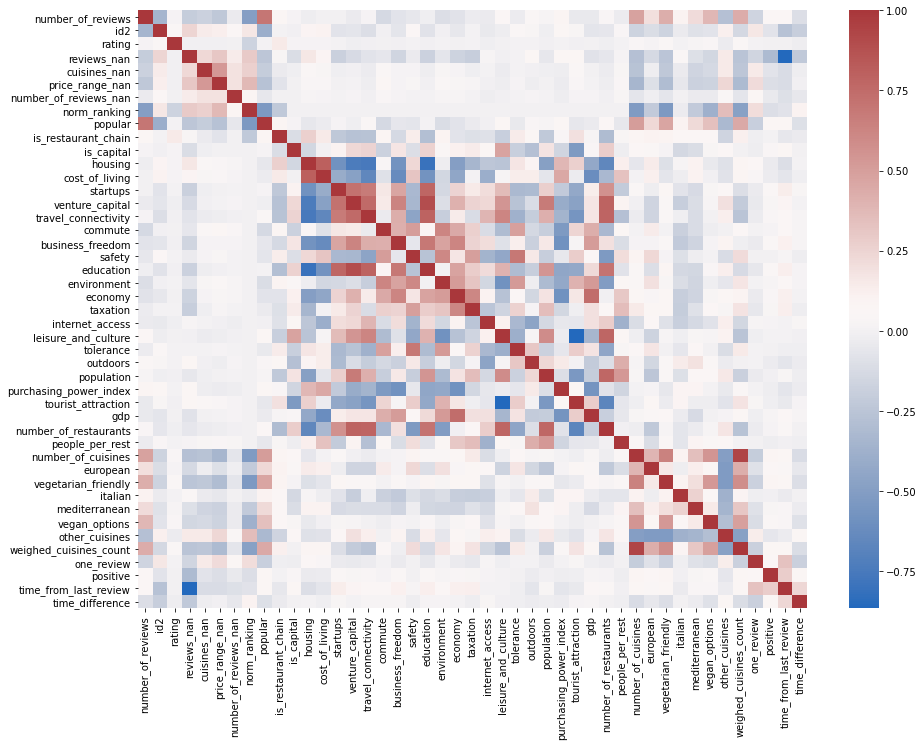

In [131]:
plt.rcParams['figure.figsize'] = (15,11)
sns.heatmap(df.drop("train", axis=1).corr(), cmap='vlag');
determinant = np.prod(np.linalg.eig(df.corr())[0])
print(f"Determinant of the matrix is {determinant}")
# Очень маленький детерминант

In [132]:
drop = features_to_drop(df.drop("rating", axis=1), cut=0.85)
# найдём признаки, скоррелированные сильнее 0.85 по модулю
drop

['number_of_cuisines', 'reviews_nan', 'tourist_attraction', 'venture_capital']

In [133]:
df.drop(drop, axis=1, inplace=True)

In [134]:
features_to_drop(df.drop("rating", axis=1), cut=0.85)

Сильноскоррелированных переменных нет


Determinant of the matrix is 1.4177104449126246e-17


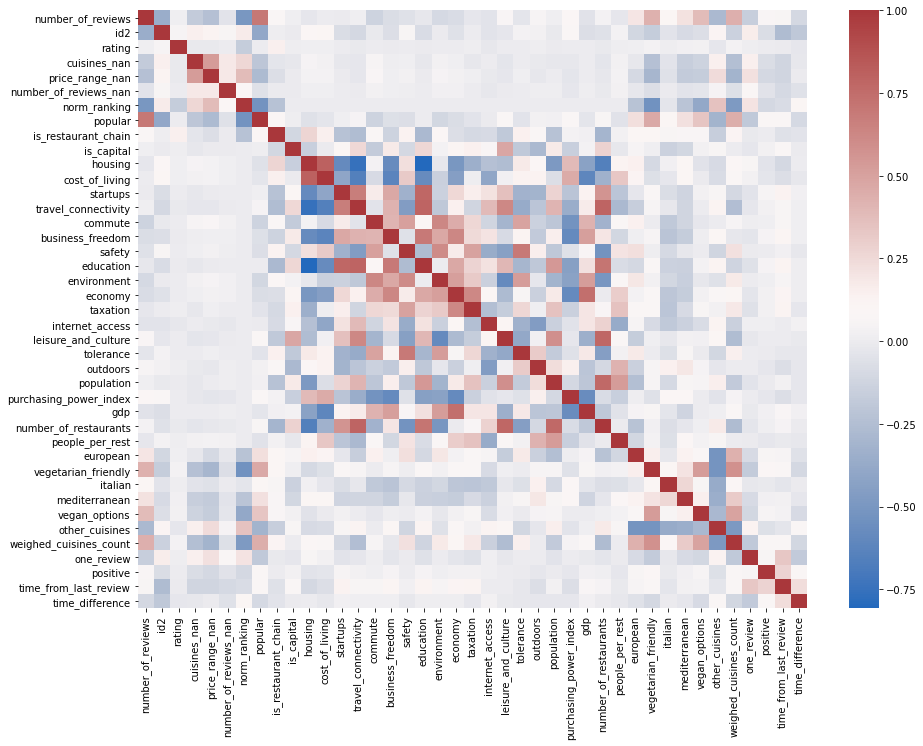

In [135]:
plt.rcParams['figure.figsize'] = (15,11)
sns.heatmap(df.drop("train", axis=1).corr(), cmap='vlag');
determinant = np.prod(np.linalg.eig(df.corr())[0])
print(f"Determinant of the matrix is {determinant}")
# Детерминант всё ещё очень маленький, но я не уверен, что с этим ещё можно сделать

## Разбиение данных

In [150]:
seed = 20726

In [151]:
train_data = df[df.train == 1].drop(["train"], axis=1)
test_data = df[df.train == 0].drop(["train", "rating"], axis=1)

In [152]:
X = train_data.drop(["rating"], axis=1)
y = train_data.rating.values

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

## Обучение модели

In [154]:
regressor = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=seed)

In [155]:
regressor.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.7s finished


RandomForestRegressor(n_jobs=-1, random_state=20726, verbose=1)

In [156]:
y_pred = regressor.predict(X_test)
y_pred

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


array([3.93 , 3.895, 4.115, ..., 2.335, 4.255, 4.42 ])

In [157]:
y_pred = (y_pred * 2).round() / 2

In [158]:
print("MAE:", mean_absolute_error(y_test, y_pred))
# MAE: 0.1696875

MAE: 0.1696875


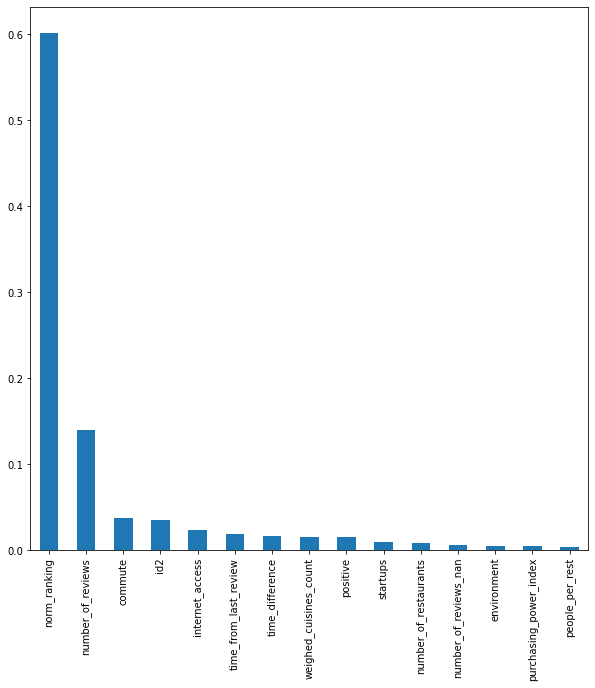

In [159]:
plt.rcParams["figure.figsize"] = (10,10)
importances = pd.Series(regressor.feature_importances_, index=X_train.columns)
importances.nlargest(15).plot.bar();

## Финальное предсказание

In [160]:
predict_submission = regressor.predict(test_data)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [161]:
predict_submission = (predict_submission * 2).round() / 2
predict_submission[:10]

array([3. , 4. , 4.5, 4.5, 4.5, 4.5, 1.5, 2.5, 4. , 4.5])

In [162]:
sample_submission["Rating"] = predict_submission

In [163]:
sample_submission.to_csv("submission.csv", index=False)